In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import preprocessing as pp
import PCA_data as pca_data

## Summary

|Model| Comments|
|-----|---------|
| Simple LR | Test $R^2$ = 12.5%|
| Ridge with gridsearch| Test $R^2$ = 12.5%|
| Simple LGBM | Test $R^2$ = 32.5%|
| Simple LGBM dropping repeated counts| Test $R^2$ = 37.3%|
| LGBM with MAE objective funct | Test $R^2$ = 38.6%|
| LGBM with MAE objective funct and scaled X | Test $R^2$ = 39.3%|
| Ridge with log transformed y | Test $R^2$ = 47.1%|
| LGBM with log transformed y | Test $R^2$ = 73.1%|


**Comments -** 
> - LGBM can be good model with feature selection
> - log transforming y can be an approach given the interpretability issue.
> - Quantile regression will be looked into


In [2]:
df = pd.read_csv("../data/train_data.zip")

In [3]:
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,1807558,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,37.0,418.67,0.116368,0.025516,0.090852
1,1806729,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,63.0,710.00,0.175774,0.020170,0.155604
2,MR00096403,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,15.0,241.24,0.112038,0.006893,0.105145
3,1806350,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,45.0,468.51,0.120088,0.003619,0.116469
4,FM00169477,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,83.0,326.05,0.132935,0.025298,0.107637


## Function for pre-processing data

In [4]:
clean_df = pp.preprocessing_na(df)
clean_df.shape

(50120, 813)

In [5]:
clean_df2 = pp.clean_categorical(clean_df.drop(columns = ['external_id', 'state']))
clean_df2.shape

(50120, 817)

In [7]:
pca_results = pca_data.pca(clean_df2)
pca_results.shape

(50120, 465)

In [6]:
pca_results_parts = pca_data.pca(clean_df2, by_groups = True)
pca_results_parts.shape

(50120, 481)

In [6]:
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

In [7]:
X_train_pca_parts = pca_data.pca_fit_transform(X_train, by_groups = True)
X_train_pca_parts.shape

(40096, 479)

In [8]:
X_test_pca_parts = pca_data.pca_transform(X_test, by_groups = True)
X_test_pca_parts.shape

(10024, 479)

In [8]:
def show_scores(model, X, y, show = True):
    """
    Shows R-squared score and mean squared error
    
    Parameters
    ----------
    model: The sklearn model
    X: numpy.ndarray        
        The X part of the data
    y: numpy.ndarray
        The y part of the data
    Returns
    -------
        rmse: (float)
        r2: (float)
            
    """        
        
    y_preds = model.predict(X)                 
    rmse = mean_squared_error(y, y_preds, squared=False)
    r2 = r2_score(y, y_preds)
    if show: 
        print("Root mean squared error: %0.3f and r^2 score: %0.3f" % (rmse,r2))
    return rmse, r2

## Modelling with Linear regression

In [9]:
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

### 1. Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train)

print('Test error: ')    
show_scores(lr, X_test, y_test)

Simple linear regression scores: 
Train error: 
Root mean squared error: 412.405 and r^2 score: 0.254
Test error: 
Root mean squared error: 668.082 and r^2 score: 0.125


(668.0819799558959, 0.12501648107849783)

### Observations 

- Very poor model with $R^2 = 12.5 \%$

### 2. SVR

### Observations
- Very long train runtime. Not feasible on whole dataset
- Very Poor model with negative $R^2$


### 3. Lasso L1

### Observations
- Same performance as simple LR 

### 4. Ridge L2

In [14]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_test, y_test)

C:\Users\saura\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.81689e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 412.451 and r^2 score: 0.254
Test error: 
Root mean squared error: 667.956 and r^2 score: 0.125


(667.9557472618134, 0.12534710245549097)

### Observations

- Same performance as Simple LR

### 4. ElasticNet L1 and L2 Regression

### Observations

- Same performance as Simple LR
- Too slow

### Step 2: Scaling all columns with MinMaxScaler

### Observations:
- Simple LR - slight improvement from last case
- Lasso performs worse than previous case
- Ridge performs same as w/o scaling
- Elastic net performs worse than all models


### Step 3: Scaling all columns with Normalizer

### Observation
- All model performs worse than the minmax scaler

### Step 4: Scaling all columns with StandardScaler

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Observation
- Standard Scaler works best for all models among other scalers
- Moving on to grid search

In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train_scaled, y_train)

print('Test error: ')    
show_scores(lr, X_test_scaled, y_test)

Simple linear regression scores: 
Train error: 
Root mean squared error: 412.408 and r^2 score: 0.254
Test error: 
Root mean squared error: 668.081 and r^2 score: 0.125


(668.0809885995218, 0.12501907782521782)

In [17]:
params = {'alpha' : [0.001, 0.1, 1, 10, 100]}


In [18]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)

clf_ridge = GridSearchCV(ridge_lr, params, cv =5)

clf_ridge.fit(X_train_scaled, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(clf_ridge, X_train_scaled, y_train)

print('Test error: ')
show_scores(clf_ridge, X_test_scaled, y_test)

Ridge regression scores: 
Train error: 
Root mean squared error: 413.193 and r^2 score: 0.251
Test error: 
Root mean squared error: 668.456 and r^2 score: 0.124


(668.4563791374494, 0.12403550893358262)

In [19]:
clf_ridge.best_params_

{'alpha': 100}

## LGBM on this data

In [20]:
lgbm = LGBMRegressor()

lgbm.fit(X_train_scaled, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train_scaled, y_train)

print('Test error: ')
show_scores(lgbm, X_test_scaled, y_test)

LGBM scores: 
Train error: 
Root mean squared error: 260.506 and r^2 score: 0.702
Test error: 
Root mean squared error: 596.266 and r^2 score: 0.303


(596.266345373865, 0.3030189791757213)

In [20]:
#Including state column in OHE

clean_df2 = pp.clean_categorical(clean_df.drop(columns = ['external_id']), to_drop= ['income_class', 'density_class', 'climate', 'state'])
print(clean_df2.shape)
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(50120, 870)


In [22]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_test, y_test)

LGBM scores: 
Train error: 
Root mean squared error: 257.290 and r^2 score: 0.710
Test error: 
Root mean squared error: 590.936 and r^2 score: 0.315


(590.936488628369, 0.31542352358410974)

### Observation 
- no improvement with state columns

In [6]:
clean_df2 = pp.clean_categorical(clean_df.drop(columns = ['external_id', 'state', 'monthly_repeated_sessions', 'historic_repeat_sessions']))
print(clean_df2.shape)
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(50120, 817)


In [9]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_test, y_test)

Ridge regression scores: 
Train error: 
Root mean squared error: 300.587 and r^2 score: 0.716
Test error: 
Root mean squared error: 306.431 and r^2 score: 0.373


(306.4313022990618, 0.37268793014293644)

**performing grid search**

In [11]:
params = {'learning_rate' : [0.01, 0.1, 1, 10, 100], 'max_depth' : [100, 500], 'n_estimators' : [100, 500] }

lgbm = LGBMRegressor(random_state = 2020)

clf_lgbm = GridSearchCV(lgbm, params, cv =5)

clf_lgbm.fit(X_train_scaled, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(clf_lgbm, X_train_scaled, y_train)

print('Test error: ')
show_scores(clf_lgbm, X_test_scaled, y_test)

Ridge regression scores: 
Train error: 
Root mean squared error: 260.506 and r^2 score: 0.702
Test error: 
Root mean squared error: 596.266 and r^2 score: 0.303


(596.266345373865, 0.3030189791757213)

In [12]:
clf_lgbm.best_params_

{'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 100}

In [13]:
#fitting lgbm with MAE without scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_test, y_test)

LGBM regression scores: 
Train error: 
Root mean squared error: 513.518 and r^2 score: 0.171
Test error: 
Root mean squared error: 303.248 and r^2 score: 0.386


(303.248308120283, 0.3856524042712979)

In [12]:
#fitting lgbm with MAE with scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train_scaled, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train_scaled, y_train)

print('Test error: ')
show_scores(lgbm, X_test_scaled, y_test)

LGBM regression scores: 
Train error: 
Root mean squared error: 512.881 and r^2 score: 0.173
Test error: 
Root mean squared error: 301.389 and r^2 score: 0.393


(301.38947057685897, 0.39316092016584714)

## Observation 
 - Model performs worse with MAE

## Log transformation

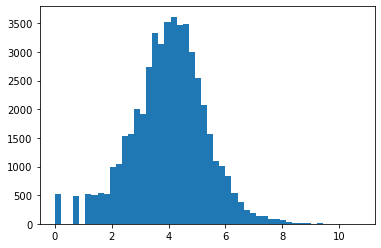

In [19]:
y_log = np.log(y[y>0])

plt.hist(y_log, bins = 50)
plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(np.where(y==0, 1, y)), test_size = 0.2, random_state = 2020)

ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_test, y_test)

C:\Users\saura\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.82301e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 1.008 and r^2 score: 0.473
Test error: 
Root mean squared error: 1.011 and r^2 score: 0.471


(1.0107769514544027, 0.47133792178179224)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(np.where(y==0, 1, y)), test_size = 0.2, random_state = 2020)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train_scaled, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train_scaled, y_train)

print('Test error: ')
show_scores(lgbm, X_test_scaled, y_test)

LGBM regression scores: 
Train error: 
Root mean squared error: 0.662 and r^2 score: 0.773
Test error: 
Root mean squared error: 0.711 and r^2 score: 0.738


(0.7112299593586098, 0.738249462025377)

## Running lgbm with PCA 

In [6]:
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

X_train_pca_parts = pca_data.pca_fit_transform(X_train)
X_test_pca_parts = pca_data.pca_transform(X_test)
X_test_pca_parts.shape

(10024, 464)

In [9]:

lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train_pca_parts, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train_pca_parts, y_train)

print('Test error: ')
show_scores(lgbm, X_test_pca_parts, y_test)

LGBM regression scores: 
Train error: 
Root mean squared error: 252.923 and r^2 score: 0.799
Test error: 
Root mean squared error: 5689.688 and r^2 score: -215.269


(5689.687597962367, -215.2689803433158)

In [13]:
X = clean_df2.drop(columns = ['unacast_session_count'])
y = clean_df2['unacast_session_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 2020)

X_train_pca_parts = pca_data.pca_fit_transform(X_train)
X_test_pca_parts = pca_data.pca_transform(X_test)

ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train_pca_parts, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train_pca_parts, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_test_pca_parts, y_test)

Ridge regression scores: 
Train error: 
Root mean squared error: 539.639 and r^2 score: 0.188
Test error: 
Root mean squared error: 55991145.552 and r^2 score: -14901799736.988


(55991145.5519386, -14901799736.988125)